In [1]:
#%pip install datasets -q
#%pip install torch -q
#%pip install transformers -q

In [2]:
from transformers import (
    AutoTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score
import numpy as np
import torch
import pandas as pd

In [3]:
# Chargement des données
path = "https://fullstackds-projects-bucket.s3.eu-west-3.amazonaws.com/data/clean_reviews_with_labels.csv"
df = pd.read_csv(path)
df.head()


,firm,date_review,overall_rating,work_life_balance,culture_values,career_opp,comp_benefits,senior_mgmt,recommend,ceo_approv,...,recommend_score,status,experience,headline_clean,pros_clean,cons_clean,full_text_clean,text,sentiment,label
0,Apple,2008-01-31,5,3.0,5.0,3.0,4.0,4.0,v,v,...,2.0,current,No information,product poeple enjoy buy,people work great not imagine life will produc...,careful job life careful need learn seperate ...,product poeple enjoy buy. people work great no...,product poeple enjoy buy people work great not...,positive,1
1,Apple,2008-02-14,4,4.0,5.0,3.0,4.0,3.0,v,v,...,2.0,current,No information,different job different creative product work,big positive enjoy job apple innovative change...,suppose con hard balance work home life,different job different creative product work....,different job different creative product work ...,positive,1
2,Apple,2008-02-15,5,4.0,5.0,5.0,5.0,5.0,v,v,...,2.0,current,No information,work apple hard job love,work place like apple opportunity change way w...,people apple live bleed edge not know future h...,work apple hard job love. work place like appl...,work apple hard job love work place like apple...,positive,1
3,Apple,2008-04-20,5,5.0,5.0,5.0,4.0,5.0,v,v,...,2.0,current,No information,retail job altogether exciting thrilling life ...,despite fact boil sell product apple make feel...,intensive training mandatory meeting month pos...,retail job altogether exciting thrilling life ...,retail job altogether exciting thrilling life ...,positive,1
4,Apple,2008-04-20,2,3.0,5.0,2.0,3.0,1.0,x,x,...,0.0,former,No information,bad choice,benefit fulltime employee great stock option r...,confidentiality not fart get reprimand way fee...,bad choice. benefit fulltime employee great st...,bad choice benefit fulltime employee great sto...,negative,0


In [4]:
# Fusionner le texte
df["full_text_raw"] = df["headline"].fillna('') + " " + df["pros"].fillna('') + " " + df["cons"].fillna('')

# Clean data
df_clean = df.dropna(subset=["label"])
df_clean = df_clean[df_clean["full_text_raw"].str.strip() != ""]

# Séparer X (les entrées) et y (la cible) pour l’entraînement du modèle
X = df_clean["full_text_raw"].tolist()
y = df_clean["label"].tolist()

#Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_data = Dataset.from_dict({'text': X_train, 'label': y_train})
test_data = Dataset.from_dict({'text': X_test, 'label': y_test})


# 3. Charger modèle et tokenizer (DistilBERT déjà fine-tuné pour la classification)
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(examples):
    return tokenizer(examples['text'], truncation=True)

train_data = train_data.map(tokenize, batched=True)
test_data = test_data.map(tokenize, batched=True)

# Data collator pour padding dynamique
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


Map:   0%|          | 0/211117 [00:00<?, ? examples/s]

Map:   0%|          | 0/52780 [00:00<?, ? examples/s]

In [5]:
print(torch.cuda.is_available())  # True — если GPU доступен
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
0
NVIDIA GeForce GTX 1070


In [6]:
import time

# Modèle (classification avec 2 classes)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Métriques
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1_weighted': f1_score(labels, preds, average='weighted'),
        'f1_macro': f1_score(labels, preds, average='macro'),
        'recall_negative': recall_score(labels, preds, pos_label=0),
    }

# Arguments de l'entrainement
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
)

# Trainer pour fine-tuning
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Lancer fine-tuning
start_time = time.time()
trainer.train()
end_time = time.time()

print(f"Le temps d'entrainement: {end_time - start_time:.2f} seconds")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\AppData\Local\Temp\ipykernel_18544\1194237014.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,F1 Macro,Recall Negative
1,0.201000,0.200380,0.928136,0.925032,0.873063,0.712026
2,0.168300,0.224208,0.930978,0.929528,0.882872,0.766597
3,0.120700,0.280630,0.930106,0.928970,0.882445,0.775208


Le temps d'entrainement: 31382.55 seconds


In [7]:
from sklearn.metrics import classification_report
import numpy as np

# Prédictions sur les données de test
predictions = trainer.predict(test_data)

# logits -> labels (classes prédites)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Classification report
print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.85      0.77      0.81      9987
    Positive       0.95      0.97      0.96     42793

    accuracy                           0.93     52780
   macro avg       0.90      0.87      0.88     52780
weighted avg       0.93      0.93      0.93     52780



Matrice de confusion

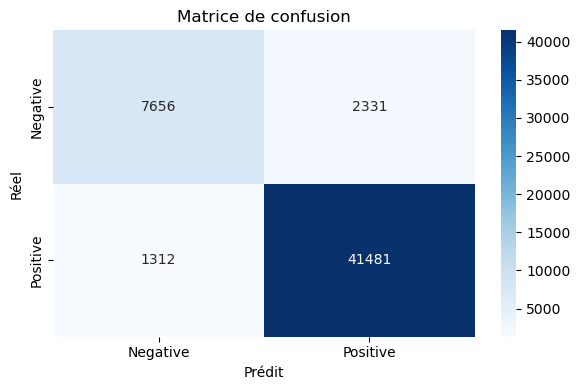

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)

# Affichage visuel
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.tight_layout()
plt.show()

In [9]:
# Sauvegarder le modèle et tokenizer
trainer.save_model("fine_tuned_bert_glassdoor")
tokenizer.save_pretrained("fine_tuned_bert_glassdoor")


('fine_tuned_bert_glassdoor\\tokenizer_config.json',
 'fine_tuned_bert_glassdoor\\special_tokens_map.json',
 'fine_tuned_bert_glassdoor\\vocab.txt',
 'fine_tuned_bert_glassdoor\\added_tokens.json',
 'fine_tuned_bert_glassdoor\\tokenizer.json')

Tester le modèle sur des phrases qu'il n'a pas vu

In [10]:
inputs = tokenizer("""Job role can get tiring overtime""", return_tensors="pt", truncation=True, padding=True)
inputs = {k: v.to(trainer.model.device) for k, v in inputs.items()}
outputs = model(**inputs)
prediction = torch.argmax(outputs.logits, dim=1)
print(prediction.item())  # 0(négatif) ou 1 (positif)

1


In [11]:
inputs = tokenizer("""I would say the company cares way to much about AHT ( Average Handling Time) rather than giving the best service.""", return_tensors="pt", truncation=True, padding=True)
inputs = {k: v.to(trainer.model.device) for k, v in inputs.items()}
outputs = model(**inputs)
prediction = torch.argmax(outputs.logits, dim=1)
print(prediction.item())  # 0(négatif) ou 1 (positif)

1


In [12]:
# Visualser la distribution de la probabilité
import torch.nn.functional as F

text = "Job role can get tiring overtime"
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
inputs = {k: v.to(model.device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
    probs = F.softmax(outputs.logits, dim=-1)
    print(f"Negative: {probs[0][0].item():.3f}, Positive: {probs[0][1].item():.3f}")

Negative: 0.049, Positive: 0.951


##### Modèle a de très bons résultats avec des avis nettement positifs ou négatifs, mais n'arrive pas toujours à discerner des commentaires négatifs ambigus et voilés.
Il confond l'ironie ou la critique voilée avec un message positif -quand le vocabulaire ne contient pas de mots explicitement négatifs comme  « mauvais », « terrible », « épuisant ».


##### Essayer de réentraîner (fine-tuning supplémentaire) le modèle sur des exemples similaires (créer un petit dataset avec des exemples des avis négatifs voilés) 

In [13]:
hard_negatives = [
    "Job role can get tiring over time",
    "The company cares more about metrics than people",
    "You're expected to prioritize speed over quality",
    "Too much focus on numbers, not enough on real impact",
    "Management is more concerned with KPIs than well-being",
    "The work environment is very results-driven, not supportive",
    "Employee feedback is often ignored",
    "Lots of talk about values, not enough action",
    "Hard to grow if you’re not part of the inner circle",
    "They preach work-life balance, but don’t practice it",
    "Recognition goes only to those who play politics",
    "Too much micromanagement for independent thinkers",
    "The tools are outdated but expectations are high",
    "Little room for creativity despite claims of innovation",
    "More energy spent on reporting than real improvements",
    "The processes are slow and bureaucratic",
    "Onboarding is rushed, you're left figuring things out",
    "Communication is very top-down",
    "Workload often exceeds what’s reasonable",
    "Good on paper, but disappointing in practice",
    "You're expected to be available after hours",
    "Deadlines are often unrealistic",
    "They say they care, but actions say otherwise",
    "Benefits sound great but are hard to access",
    "Diversity is talked about, not actually valued",
    "Middle management lacks leadership skills",
    "Constructive criticism is not well received",
    "You’re constantly being monitored",
    "High turnover makes teams unstable",
    "Meetings are more about appearances than substance",
    "Too much red tape for simple tasks",
    "Training is minimal, but expectations are high",
    "Raises are rare and not performance-based",
    "Career growth feels like an illusion",
    "Frequent reorganizations cause confusion",
    "Leadership lacks transparency",
    "You’re praised in private, criticized in public",
    "Flexibility depends on your manager’s mood",
    "Mental health is mentioned but not prioritized",
    "Good ideas are often ignored",
    "Feedback loops are broken",
    "Remote workers are treated as second-class",
    "Initiative is not encouraged",
    "Success depends more on who you know",
    "Micromanagement kills morale",
    "Long hours are the unspoken expectation",
    "Internal politics get in the way of progress",
    "They celebrate wins but hide losses",
    "Low pay for the level of responsibility",
    "You’re left out of key decisions",
    "Mistakes are punished, not learned from"
]


df_hard_negatives = pd.DataFrame({'text': hard_negatives, 'label': [0]*len(hard_negatives)})
df_hard_negatives.to_csv("hard_negatives.csv", index=False)

In [14]:
# Charger le mini-dataset

df_extra = pd.read_csv("hard_negatives.csv")

# Transformer en Dataset Hugging Face
extra_dataset = Dataset.from_pandas(df_extra)

# Tokenization
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
extra_dataset = extra_dataset.map(lambda x: tokenizer(x["text"], truncation=True), batched=True)

# Fine-tuning
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification, DataCollatorWithPadding
from sklearn.metrics import accuracy_score, f1_score, recall_score

model = AutoModelForSequenceClassification.from_pretrained("fine_tuned_bert_glassdoor")  # ou le chemin vers le dernier checkpoint

training_args = TrainingArguments(
    output_dir="./results_finetune_extra",
    num_train_epochs=5,
    per_device_train_batch_size=4,
    learning_rate=1e-5,
    save_strategy="epoch",
    logging_steps=5,
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def compute_metrics(pred):
    preds = pred.predictions.argmax(-1)
    labels = pred.label_ids
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1_macro': f1_score(labels, preds, average='macro'),
        'recall_neg': recall_score(labels, preds, pos_label=0),
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=extra_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.save_model("bert_glassdoor_finetuned_hard_negatives")
tokenizer.save_pretrained("bert_glassdoor_finetuned_hard_negatives")

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

C:\Users\user\AppData\Local\Temp\ipykernel_18544\1046005811.py:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
5,0.491700
10,0.589200
15,0.190400
20,0.038000
25,0.132500
30,0.073700
35,0.021000
40,0.023400
45,0.009000
50,0.006700


('bert_glassdoor_finetuned_hard_negatives\\tokenizer_config.json',
 'bert_glassdoor_finetuned_hard_negatives\\special_tokens_map.json',
 'bert_glassdoor_finetuned_hard_negatives\\vocab.txt',
 'bert_glassdoor_finetuned_hard_negatives\\added_tokens.json',
 'bert_glassdoor_finetuned_hard_negatives\\tokenizer.json')

In [15]:
# Charger tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Charger les deux versions de modèle
model_before = AutoModelForSequenceClassification.from_pretrained("fine_tuned_bert_glassdoor")
model_after = AutoModelForSequenceClassification.from_pretrained("bert_glassdoor_finetuned_hard_negatives")

# Définir le device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_before.to(device)
model_after.to(device)

# Exemple de phrase
text = "I would say the company cares way to much about AHT ( Average Handling Time) rather than giving the best service."
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Prédiction avant l'entrainement supplémentaire
with torch.no_grad():
    outputs_before = model_before(**inputs)
    probs_before = F.softmax(outputs_before.logits, dim=-1)

# Prédiction après l'entrainement
with torch.no_grad():
    outputs_after = model_after(**inputs)
    probs_after = F.softmax(outputs_after.logits, dim=-1)

# Résultats
print(f"\nPhrase: {text}")
print(f"Before fine-tuning:  Negative: {probs_before[0][0]:.3f}, Positive: {probs_before[0][1]:.3f}")
print(f"After fine-tuning:   Negative: {probs_after[0][0]:.3f}, Positive: {probs_after[0][1]:.3f}")


Phrase: I would say the company cares way to much about AHT ( Average Handling Time) rather than giving the best service.
Before fine-tuning:  Negative: 0.026, Positive: 0.974
After fine-tuning:   Negative: 0.991, Positive: 0.009


In [16]:
# Charger tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Charger les deux versions de modèle
model_before = AutoModelForSequenceClassification.from_pretrained("fine_tuned_bert_glassdoor")
model_after = AutoModelForSequenceClassification.from_pretrained("bert_glassdoor_finetuned_hard_negatives")

# Définir le device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_before.to(device)
model_after.to(device)

# Exemple de phrase
text = "Job role can get tiring overtime"
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Prédiction avant l'entrainement supplémentaire
with torch.no_grad():
    outputs_before = model_before(**inputs)
    probs_before = F.softmax(outputs_before.logits, dim=-1)

# Prédiction après l'entrainement
with torch.no_grad():
    outputs_after = model_after(**inputs)
    probs_after = F.softmax(outputs_after.logits, dim=-1)

# Résultats
print(f"\nPhrase: {text}")
print(f"Before fine-tuning:  Negative: {probs_before[0][0]:.3f}, Positive: {probs_before[0][1]:.3f}")
print(f"After fine-tuning:   Negative: {probs_after[0][0]:.3f}, Positive: {probs_after[0][1]:.3f}")


Phrase: Job role can get tiring overtime
Before fine-tuning:  Negative: 0.049, Positive: 0.951
After fine-tuning:   Negative: 0.968, Positive: 0.032


In [17]:
# Charger tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Charger les deux versions de modèle
model_before = AutoModelForSequenceClassification.from_pretrained("fine_tuned_bert_glassdoor")
model_after = AutoModelForSequenceClassification.from_pretrained("bert_glassdoor_finetuned_hard_negatives")

# Définir le device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_before.to(device)
model_after.to(device)

# Exemple de phrase
text = "A lot of flexibility when it comes to holidays, didn’t need to speak to HR, just did my own booking. Great TL, left me to my own devices and was not constantly micromanaging me"
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Prédiction avant l'entrainement supplémentaire
with torch.no_grad():
    outputs_before = model_before(**inputs)
    probs_before = F.softmax(outputs_before.logits, dim=-1)

# Prédiction après l'entrainement
with torch.no_grad():
    outputs_after = model_after(**inputs)
    probs_after = F.softmax(outputs_after.logits, dim=-1)

# Résultats
print(f"\nPhrase: {text}")
print(f"Before fine-tuning:  Negative: {probs_before[0][0]:.3f}, Positive: {probs_before[0][1]:.3f}")
print(f"After fine-tuning:   Negative: {probs_after[0][0]:.3f}, Positive: {probs_after[0][1]:.3f}")


Phrase: A lot of flexibility when it comes to holidays, didn’t need to speak to HR, just did my own booking. Great TL, left me to my own devices and was not constantly micromanaging me
Before fine-tuning:  Negative: 0.005, Positive: 0.995
After fine-tuning:   Negative: 0.033, Positive: 0.967


Les résultats montrent **une amélioration significative** de la capacité du modèle à détecter des formulations critiques plus implicites, tout en conservant une bonne précision sur les phrases explicitement positives. Par exemple, la phrase ***« Job role can get tiring overtime »***, initialement classée comme très positive (probabilité négative : 0.028), est désormais correctement reconnue comme négative (probabilité : 0.973).

Ce second entraînement a donc permis **d’affiner le jugement** du modèle sur les cas ambigus, rendant les prédictions plus robustes et réalistes dans un contexte d’analyse de sentiments sur les avis professionnels.

In [18]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

True
NVIDIA GeForce GTX 1070


In [19]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# 1. Загрузка модели и токенизатора
model_path = "bert_glassdoor_finetuned_hard_negatives"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# 2. Подготовка данных
df['full_text'] = df['headline_clean'].fillna('') + ' ' + df['pros_clean'].fillna('') + ' ' + df['cons_clean'].fillna('')
firms = df['firm'].unique()

results = []

for firm in tqdm(firms):
    firm_df = df[df['firm'] == firm]
    texts = firm_df['full_text'].tolist()

    if len(texts) == 0:
        continue

    # Токенизация
    encoded = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    dataset = TensorDataset(encoded['input_ids'], encoded['attention_mask'])
    loader = DataLoader(dataset, batch_size=32)

    preds = []
    with torch.no_grad():
        for batch in loader:
            input_ids, attention_mask = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
            pred = torch.argmax(probs, dim=1)
            preds.extend(pred.cpu().numpy())

    del encoded, outputs
    torch.cuda.empty_cache()
    
    positive = sum(1 for p in preds if p == 1)
    total = len(preds)
    sentiment_score = positive / total if total > 0 else None
    results.append({'firm': firm, 'bert_sentiment_score': sentiment_score, 'n_reviews': total})

# 3. Сохранение
bert_results = pd.DataFrame(results)
bert_results.to_csv("bert_sentiment_by_firm.csv", index=False)

100%|██████████████████████████████████████████████████████████████████████████████| 10/10 [3:03:04<00:00, 1098.47s/it]


In [20]:
bert_results.head(10)

,firm,bert_sentiment_score,n_reviews
0,Apple,0.787912,17488
1,Deloitte,0.782902,36366
2,EY,0.766991,25720
3,IBM,0.673841,43350
4,J-P-Morgan,0.717807,19678
5,KPMG,0.755867,18322
6,McDonald-s,0.461218,33895
7,Microsoft,0.783171,21962
8,Oracle,0.671875,21824
9,PwC,0.766764,25292


In [21]:
baseline_model_score=[0.90, 0.90, 0.89, 0.82, 0.85, 0.88, 0.71, 0.90, 0.82, 0.89]

In [22]:
scores_comparison = pd.DataFrame({
    "firm": bert_results["firm"],
    "bert_sentiment_score": bert_results["bert_sentiment_score"],
    "baseline_model_score": baseline_model_score
})
scores_comparison.head(10)

,firm,bert_sentiment_score,baseline_model_score
0,Apple,0.787912,0.90
1,Deloitte,0.782902,0.90
2,EY,0.766991,0.89
3,IBM,0.673841,0.82
4,J-P-Morgan,0.717807,0.85
5,KPMG,0.755867,0.88
6,McDonald-s,0.461218,0.71
7,Microsoft,0.783171,0.90
8,Oracle,0.671875,0.82
9,PwC,0.766764,0.89


Visualiser la matrice de confusion du modèle réentrainé

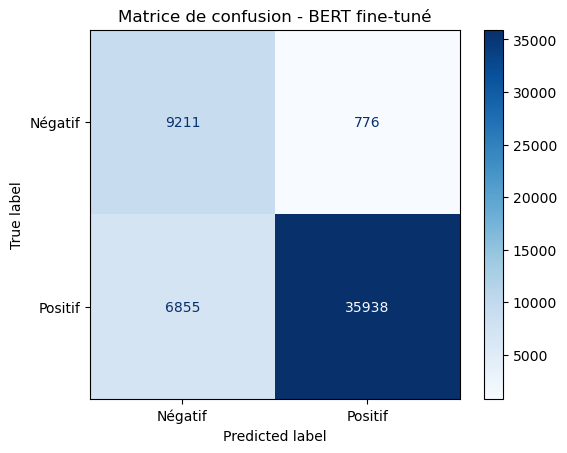

              precision    recall  f1-score   support

     Négatif       0.57      0.92      0.71      9987
     Positif       0.98      0.84      0.90     42793

    accuracy                           0.86     52780
   macro avg       0.78      0.88      0.81     52780
weighted avg       0.90      0.86      0.87     52780



In [23]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Charger modèle et tokenizer
model_path = "bert_glassdoor_finetuned_hard_negatives"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Préparer les données de test
texts = test_data['text']
true_labels = test_data['label']

# Tokenisation
encoded = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
dataset = TensorDataset(encoded['input_ids'], encoded['attention_mask'])
loader = DataLoader(dataset, batch_size=32)

# Prédictions
preds = []

with torch.no_grad():
    for batch in loader:
        input_ids, attention_mask = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        pred = torch.argmax(probs, dim=1)
        preds.extend(pred.cpu().numpy())

# Affichage de la matrice de confusion
cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Négatif', 'Positif'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion - BERT fine-tuné")
plt.show()

# (optionnel) Rapport complet
print(classification_report(true_labels, preds, target_names=["Négatif", "Positif"]))

#### Conclusion:
Après fine-tuning, le modèle a montré une **amélioration significative du rappel (recall)** pour **la classe Négatif** (de 0.77 à 0.92), ce qui signifie qu’il identifie beaucoup plus de commentaires négatifs qu’avant. Cependant, cette amélioration s’accompagne d’une **baisse du précision** (de 0.85 à 0.57), ce qui entraîne plus de faux positifs pour les avis négatifs.

Pour un usage orienté détection de feedbacks négatifs (ex. modération, analyse de risques), le modèle après fine-tuning est plus adapté.

Mais pour calculer un **score de sentiment global par entreprise**, où l’équilibre entre précision et rappel est important, le **modèle avant fine-tuning est préférable** — il est plus stable et moins biaisé vers le négatif.
